In [216]:
# !pip install spotipy

In [272]:
import sys
import spotipy
import yaml
import spotipy.util as util
from pprint import pprint

def load_config():
    global user_config
    stream = open('config.yaml')
    user_config = yaml.load(stream)

load_config()

token = util.prompt_for_user_token(user_config['username'], scope='playlist-modify-private,playlist-modify-public,user-modify-playback-state,user-read-playback-state', client_id=user_config['client_id'], client_secret=user_config['client_secret'], redirect_uri=user_config['redirect_uri'])
if token:
    sp = spotipy.Spotify(auth=token)
    print(f'Token acquired: {token}')
else:
    print ("Can't get token for", user_config['username'])

Token acquired: BQBjOVRg-pSnYvh6KaUq2PRRM3KdcuYoK1qXjYEIJ_Al5lX0K5UijZsE8j6sOdsJyyZgpSuQ0GNOV-lOrsQ4QCNOwtiVr6PPKsM9cdk6gGNIkK3kUbBKDTjRAYRbG5FiBwijFjjiwBsnAEilZgOYs1wh-fs3BOWTp5LpApTvHNBpmXpYyzmmwAXag0cB7fvVWro8nfSL3SVw1H4oeLxnnlmJrKivMn1x7UeQ0G0dzfKXTQANN9hvzKt7lNmNmV55tvKS6g0uSyXGwSXgcTDaCF4imYZ5gACSNRk2cTQ5c-BH_rSJRIjPlTOoL87Rnazxv4_LEBNW


/tmp/ipykernel_9774/2318982454.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  user_config = yaml.load(stream)


In [218]:
song_groupings = []

for i in range(0, 2):
    song_groupings.append(sp.playlist_items(user_config['playlist_id'], offset=i*100))


In [219]:
import re

artist_counts = {}
dates_added = {}

for grouping in song_groupings:
    for song in grouping['items']:
        artist = song['track']['artists'][0]['name']
        if artist in artist_counts:
            artist_counts[artist] += 1
        else:
            artist_counts[artist] = 1
        
        date = re.search(r"\d+-\d+", song['added_at']).group(0)
        if date not in dates_added:
            dates_added[date] = 1
        else:
            dates_added[date] += 1

# pprint(artist_counts)

print(f"Total artist references: {sum(artist_counts.values())}")
print(f"Total songs: {sum([len(grouping['items']) for grouping in song_groupings])}")
print(dates_added)

Total artist references: 186
Total songs: 186
{'2022-02': 24, '2022-03': 4, '2022-05': 7, '2022-06': 2, '2022-08': 4, '2022-09': 1, '2022-11': 1, '2023-03': 3, '2023-04': 6, '2023-06': 6, '2023-07': 6, '2023-08': 4, '2023-10': 14, '2023-11': 10, '2023-12': 5, '2024-01': 17, '2024-03': 2, '2024-04': 12, '2024-05': 21, '2024-06': 37}


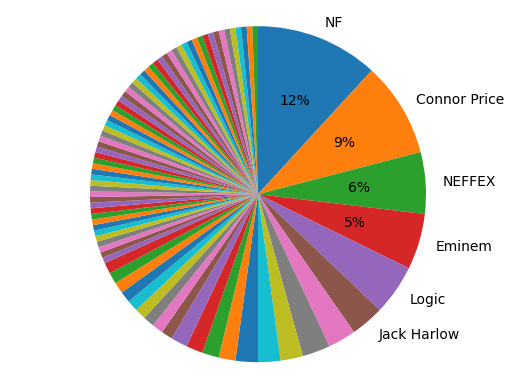

In [220]:
# create pie chart of artist counts
def autopct_more_than_threshold(pct):
    return ('%1.f%%' % pct) if pct > 5 else ''

import matplotlib.pyplot as plt

# sort in decreasing order
artist_counts = {k: v for k, v in sorted(artist_counts.items(), key=lambda item: item[1], reverse=True)}
labels = list(map(lambda x: x if artist_counts[x] > 5 else '', artist_counts.keys()))

plt.pie(artist_counts.values(), labels=labels, autopct=autopct_more_than_threshold, counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

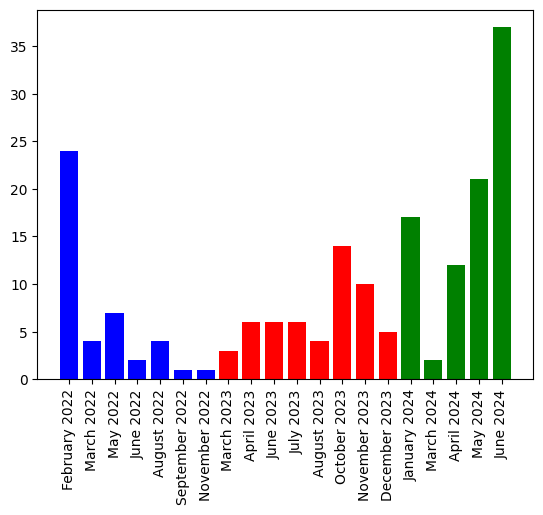

In [221]:
import calendar

# create bar graph of dates added
months = [calendar.month_name[int(date[-2:])] + ' ' + date[:4] for date in dates_added.keys()]

color_map = {
    '2022': 'blue',
    '2023': 'red',
    '2024': 'green',
}
colors = [color_map[month[-4:]] for month in months]
plt.bar(months, dates_added.values(), color=colors)
plt.xticks(rotation=90)
plt.show()

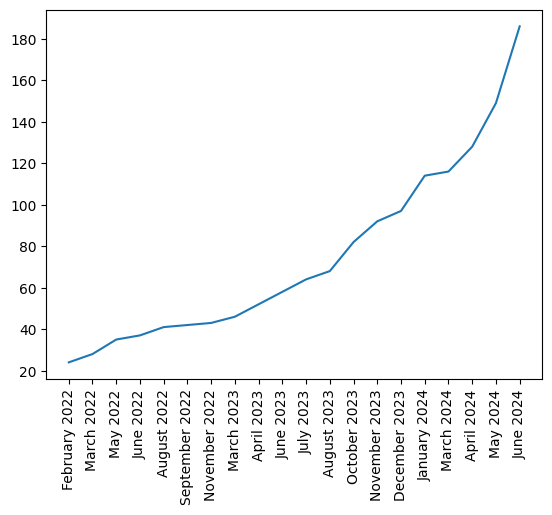

In [222]:
# create an accumaulation graph of dates added
accumulated_dates_added = {}
accumulated_count = 0

index = 0
for date in dates_added:
    accumulated_count += dates_added[date]
    accumulated_dates_added[months[index]] = accumulated_count

    index += 1

plt.plot(accumulated_dates_added.keys(), accumulated_dates_added.values())
plt.xticks(rotation=90)
plt.show()

In [223]:
# sp.pause_playback()

In [224]:
# sp.start_playback()

In [225]:
# sp.previous_track()

In [226]:
# sp.next_track()

In [227]:
pprint(sp.current_playback())

{'actions': {'disallows': {'resuming': True,
                           'toggling_repeat_context': True,
                           'toggling_repeat_track': True,
                           'toggling_shuffle': True}},
 'context': {'external_urls': {'spotify': 'https://open.spotify.com/playlist/6jXha8BR9stmNI4KVv09B8'},
             'href': 'https://api.spotify.com/v1/playlists/6jXha8BR9stmNI4KVv09B8',
             'type': 'playlist',
             'uri': 'spotify:playlist:6jXha8BR9stmNI4KVv09B8'},
 'currently_playing_type': 'track',
 'device': {'id': 'f595be2f362872301a0dacfff00c506196453649',
            'is_active': True,
            'is_private_session': False,
            'is_restricted': False,
            'name': 'caleb-XPS-15-9500',
            'supports_volume': True,
            'type': 'Computer',
            'volume_percent': 100},
 'is_playing': True,
 'item': {'album': {'album_type': 'single',
                    'artists': [{'external_urls': {'spotify': 'https://open.spoti

In [228]:
import requests
from bs4 import BeautifulSoup
import time

In [229]:
def lyrics_request(song_notation):
    server = 'genius.com'
    request = requests.get(f"https://{server}/{song_notation}")

    if request.status_code == 200:
        html_code = BeautifulSoup(request.text, features='html.parser')
        spans = html_code.find("div", {"data-lyrics-container": "true"}).find_all('span')

        if spans is None:
            print('Lyrics not found')
        else:
            lyrics = ''
            for span in spans:
                if span.get_text() != '':
                    lyrics += span.get_text() + '\n'
            return lyrics
    else:
        print('Request failed: status code', request.status_code)
        
    return None
    
def notation(raw_song_name):
    song_notations = []
    
    raw_song_name.replace('&' , 'and')

    raw_song_name.replace("'" , "")
    song_notations.append(raw_song_name)

    dashindexs = raw_song_name.find('---')
    song_notations.append(raw_song_name[:dashindexs + 1])

    return song_notations

def print_lyrics():
    current_song = sp.current_playback()
    artist = current_song['item']['artists'][0]['name']
    song_name = current_song['item']['name']

    song_url = '{}-{}-lyrics'.format(str(artist).strip().replace(' ', '-'),
                                    str(song_name).strip().replace(' ', '-'))

    print(song_url)

    lyrics = lyrics_request(song_url)
    print(lyrics)

print_lyrics()

conscience-CHALK-IT-UP-lyrics



In [233]:
import numpy as np

# line graph of the danceability of the songs in the playlist
danceability = []
energy = []
speechiness = []
for grouping in song_groupings:
    track_ids = []
    for song in grouping['items']:
        track_ids.append(song['track']['id'])

    audio_features = sp.audio_features(track_ids)
    for feature in audio_features:
        danceability.append(feature['danceability'])
        energy.append(feature['energy'])
        speechiness.append(feature['speechiness'])

Correlation co-efficient between danceability and energy: -0.05662642461059239
Correlation co-efficient between danceability and speechiness: 0.11415150858665563


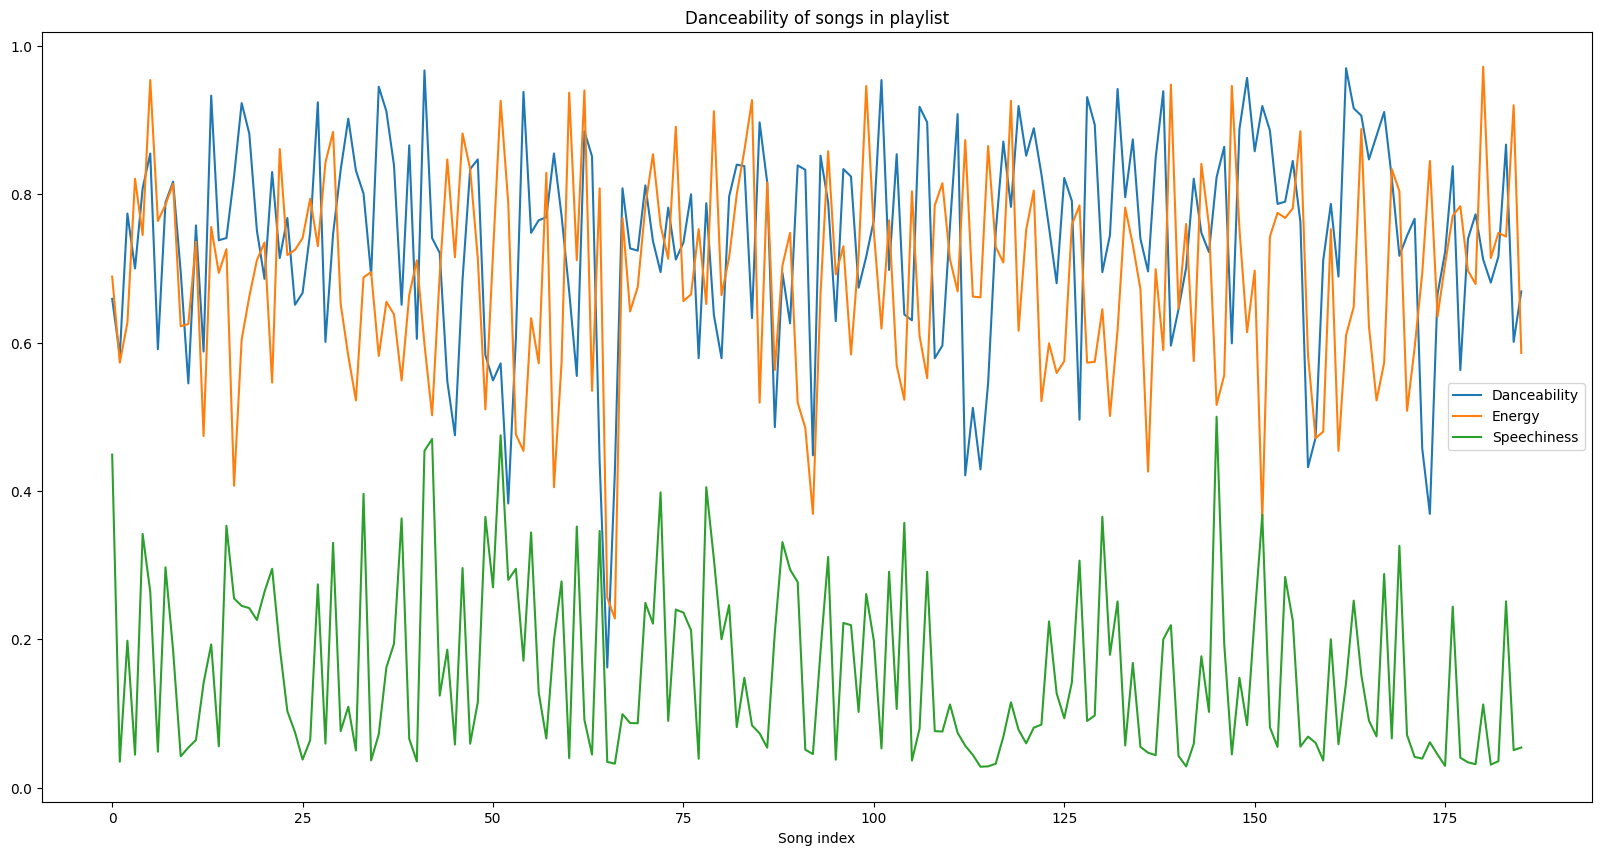

In [234]:
print("Correlation co-efficient between danceability and energy:", np.corrcoef(danceability, energy)[0, 1])
print("Correlation co-efficient between danceability and speechiness:", np.corrcoef(danceability, speechiness)[0, 1])

plt.figure(figsize=(20, 10))
plt.plot(danceability)
plt.plot(energy)
plt.plot(speechiness)
plt.xlabel('Song index')
plt.legend(['Danceability', 'Energy', 'Speechiness'])
plt.title('Danceability of songs in playlist')
plt.show()

Percent within one standard deviation of the mean: 67.74193548387096


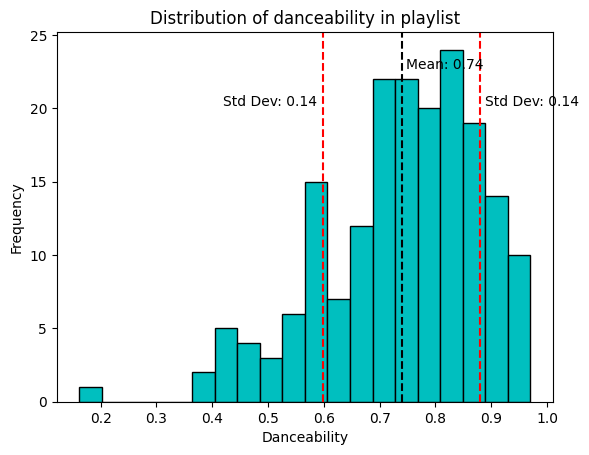

In [270]:
percent_within_std_dev = len([d for d in danceability if mean_danceability-std_dev_danceability <= d <= mean_danceability+std_dev_danceability])/len(danceability) * 100
print("Percent within one standard deviation of the mean:", percent_within_std_dev)

# plot distribution of danceability
plt.hist(danceability, bins=20, color='c', edgecolor='black')

mean_danceability = np.mean(danceability)
std_dev_danceability = np.std(danceability)
plt.axvline(mean_danceability, color='k', linestyle='dashed')
plt.axvline(mean_danceability+std_dev_danceability, color='r', linestyle='dashed')
plt.axvline(mean_danceability-std_dev_danceability, color='r', linestyle='dashed')
plt.text(mean_danceability*1.01, plt.ylim()[1]*0.9, 'Mean: {:.2f}'.format(mean_danceability))
plt.text((mean_danceability+std_dev_danceability)*1.01, plt.ylim()[1]*0.8, 'Std Dev: {:.2f}'.format(std_dev_danceability))
plt.text((mean_danceability-std_dev_danceability)*0.70, plt.ylim()[1]*0.8, 'Std Dev: {:.2f}'.format(std_dev_danceability))
plt.xlabel('Danceability')
plt.ylabel('Frequency')
plt.title('Distribution of danceability in playlist')
plt.show()

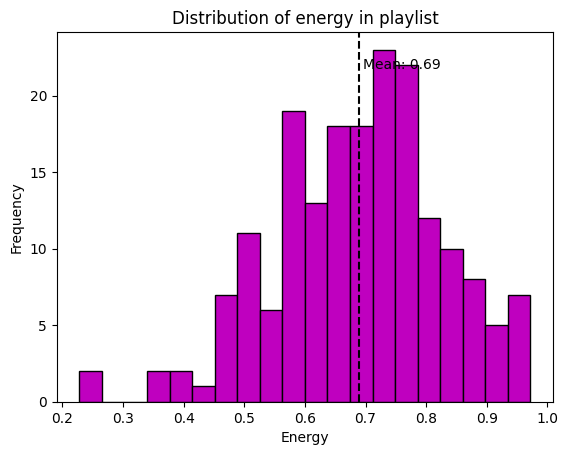

In [258]:
plt.hist(energy, bins=20, color='m', edgecolor='black')

mean_energy = np.mean(energy)
plt.axvline(mean_energy, color='k', linestyle='dashed')
plt.text(mean_energy*1.01, plt.ylim()[1]*0.9, 'Mean: {:.2f}'.format(mean_energy))
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Distribution of energy in playlist')
plt.show()

In [291]:
song = sp.recommendations(seed_genres=['pop', 'rap', 'electronic'], limit=1)

print("artist:", song['tracks'][0]['artists'][0]['name'])
print("song:", song['tracks'][0]['name'])
print("link:", song['tracks'][0]['external_urls']['spotify'])

artist: Calvin Harris
song: You Used to Hold Me
link: https://open.spotify.com/track/1SJWKuVWzg2mXY6dMp9Rsp
